Library Import

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import monai
from monai.transforms import (Compose, 
                              EnsureChannelFirstd, 
                              LoadImaged, 
                              NormalizeIntensityd, 
                              ToTensord, 
                              Resized, 
                              RandFlipd,
                              RandRotate90d,
                              RandGaussianNoised,
                              RandAdjustContrastd)
from monai.data import Dataset
from monai.utils import set_determinism
set_determinism(seed=42)  

from sklearn.model_selection import train_test_split

Dataset Loading

In [45]:
%cd D:/DATASETS/OTITIS-MEDIA/OTITIS-MEDIA

dataset_path = "eardrumDs"
aom_dir = os.path.join(dataset_path, "Abnormal", "AOM")
com_dir = os.path.join(dataset_path, "Abnormal", "chornic")


D:\DATASETS\OTITIS-MEDIA\OTITIS-MEDIA


In [46]:
aom_images = sorted(glob.glob(f"{aom_dir}/*.tiff", recursive=True))
com_images = sorted(glob.glob(f"{com_dir}/**/*.tiff", recursive=True))

print(f"No. of AOM Images: {len(aom_images)}")
print(f"No. of COM Images: {len(com_images)}")


No. of AOM Images: 119
No. of COM Images: 63


In [47]:
def visualize(normal_image, abnormal_image):
    aom = cv2.cvtColor(cv2.imread(normal_image), cv2.COLOR_BGR2RGB)
    com = cv2.cvtColor(cv2.imread(abnormal_image), cv2.COLOR_BGR2RGB)
    

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(aom)
    plt.title("AOM")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(com)
    plt.title("COM")
    plt.axis("off")

    
    plt.tight_layout()
    plt.show()

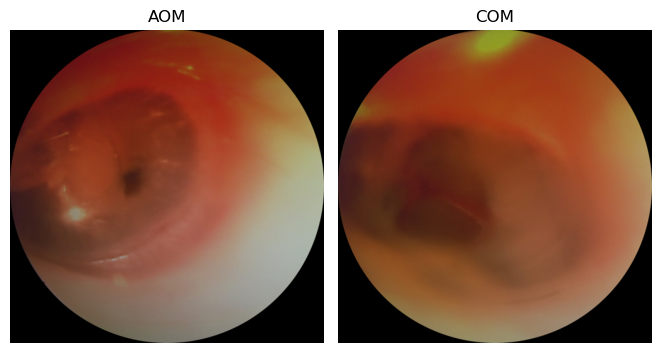

In [48]:
visualize(aom_images[5], com_images[2])

In [49]:
data_dict = []
data_dict.extend([{'image': f, 'class': 0} for f in aom_images])
data_dict.extend([{'image': f, 'class': 1} for f in com_images])

len(data_dict)

182

In [50]:
train_transform = Compose([
    LoadImaged(keys=["image"], reader="PILReader"),
    EnsureChannelFirstd(keys=["image"]),
    #Resized(keys=["image"], spatial_size=(224, 224), mode='bilinear'),
    NormalizeIntensityd(keys=["image"]),
    RandFlipd(keys=["image"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image"], prob=0.5, spatial_axis=1),
    RandRotate90d(keys=["image"], prob=0.5, spatial_axes = (0,1)),
    RandGaussianNoised(keys=["image"], prob=0.3, mean=0, std=0.05),
    RandAdjustContrastd(keys=["image"], prob=0.3),
    ToTensord(keys=["image", "class"])
])

val_transform = Compose([
    LoadImaged(keys=["image"], reader="PILReader"),
    EnsureChannelFirstd(keys=["image"]),
    #Resized(keys=["image"], spatial_size=(224, 224), mode='bilinear'),
    NormalizeIntensityd(keys=["image"]),
    ToTensord(keys=["image", "class"])
])

In [51]:
train_dict, val_dict = train_test_split(data_dict, test_size=0.2, train_size=0.8, random_state=4)
print("Training Data:", len(train_dict))
print("Validation Data:", len(val_dict))

Training Data: 145
Validation Data: 37


In [52]:
for f in val_dict:
    print(f["image"])

eardrumDs\Abnormal\AOM\aom_21.tiff
eardrumDs\Abnormal\AOM\aom_71.tiff
eardrumDs\Abnormal\chornic\chronic_38.tiff
eardrumDs\Abnormal\chornic\chronic_47.tiff
eardrumDs\Abnormal\chornic\chronic_27.tiff
eardrumDs\Abnormal\AOM\aom_34.tiff
eardrumDs\Abnormal\chornic\chronic_54.tiff
eardrumDs\Abnormal\chornic\chronic_32.tiff
eardrumDs\Abnormal\AOM\aom_92.tiff
eardrumDs\Abnormal\AOM\aom_22.tiff
eardrumDs\Abnormal\AOM\aom_60.tiff
eardrumDs\Abnormal\AOM\aom_61.tiff
eardrumDs\Abnormal\AOM\aom_32.tiff
eardrumDs\Abnormal\AOM\aom_10.tiff
eardrumDs\Abnormal\AOM\aom_64.tiff
eardrumDs\Abnormal\chornic\chronic_57.tiff
eardrumDs\Abnormal\chornic\chronic_51.tiff
eardrumDs\Abnormal\chornic\chronic_4.tiff
eardrumDs\Abnormal\AOM\aom_104.tiff
eardrumDs\Abnormal\AOM\aom_111.tiff
eardrumDs\Abnormal\chornic\chronic_31.tiff
eardrumDs\Abnormal\AOM\aom_115.tiff
eardrumDs\Abnormal\chornic\chronic_8.tiff
eardrumDs\Abnormal\AOM\aom_66.tiff
eardrumDs\Abnormal\chornic\chronic_40.tiff
eardrumDs\Abnormal\chornic\chronic_1

In [53]:
"""
des_dir = "Validataion_data_aom_com"
os.makedirs(des_dir, exist_ok=True)

import shutil
for f in val_dict:
    shutil.copy(f["image"], des_dir)

"""

'\ndes_dir = "Validataion_data_aom_com"\nos.makedirs(des_dir, exist_ok=True)\n\nimport shutil\nfor f in val_dict:\n    shutil.copy(f["image"], des_dir)\n\n'

In [54]:
def count_classes(data):
    return {
        0: [sum(d['class'] == 0 for d in data), f"{sum(d['class'] == 0 for d in data)/len(data)*100:.2f}%"],
        1: [sum(d['class'] == 1 for d in data), f"{sum(d['class'] == 1 for d in data)/len(data)*100:.2f}%"],

    }

train_counts = count_classes(train_dict)
val_counts   = count_classes(val_dict)

print("No. of Train Data in respective class:", train_counts)
print("No. of Val Data in respective class:", val_counts)


No. of Train Data in respective class: {0: [97, '66.90%'], 1: [48, '33.10%']}
No. of Val Data in respective class: {0: [22, '59.46%'], 1: [15, '40.54%']}


In [55]:
train_ds = Dataset(data=train_dict, transform=train_transform)
val_ds = Dataset(data=val_dict, transform=val_transform)

train_loader = DataLoader(dataset=train_ds, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_ds, batch_size=8, shuffle=False, num_workers=0)

In [56]:
batch = next(iter(val_loader))
images, labels = batch["image"], batch["class"]

print("Image batch shape:", images.shape) 
print("Label batch shape:", labels.shape)   


Image batch shape: torch.Size([8, 3, 500, 500])
Label batch shape: torch.Size([8])


In [57]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

set_determinism(seed=40)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = MobileNet_V3_Large_Weights.IMAGENET1K_V1
model = mobilenet_v3_large(weights=weights, dropout=0.3)

model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, 2)
model = model.to(device)

In [58]:
for k, v in model.state_dict().items():
    print(k, v.shape)

features.0.0.weight torch.Size([16, 3, 3, 3])
features.0.1.weight torch.Size([16])
features.0.1.bias torch.Size([16])
features.0.1.running_mean torch.Size([16])
features.0.1.running_var torch.Size([16])
features.0.1.num_batches_tracked torch.Size([])
features.1.block.0.0.weight torch.Size([16, 1, 3, 3])
features.1.block.0.1.weight torch.Size([16])
features.1.block.0.1.bias torch.Size([16])
features.1.block.0.1.running_mean torch.Size([16])
features.1.block.0.1.running_var torch.Size([16])
features.1.block.0.1.num_batches_tracked torch.Size([])
features.1.block.1.0.weight torch.Size([16, 16, 1, 1])
features.1.block.1.1.weight torch.Size([16])
features.1.block.1.1.bias torch.Size([16])
features.1.block.1.1.running_mean torch.Size([16])
features.1.block.1.1.running_var torch.Size([16])
features.1.block.1.1.num_batches_tracked torch.Size([])
features.2.block.0.0.weight torch.Size([64, 16, 1, 1])
features.2.block.0.1.weight torch.Size([64])
features.2.block.0.1.bias torch.Size([64])
feature

In [59]:
from fvcore.nn import FlopCountAnalysis, parameter_count

x = torch.randn(16, 3, 224, 224).to(device)
flops = FlopCountAnalysis(model, x)
params = parameter_count(model)

print(f"Total FLOPs: {flops.total():,}")
print(f"Total Params: {params['']:,}")

Unsupported operator aten::add_ encountered 56 time(s)
Unsupported operator aten::hardswish_ encountered 21 time(s)
Unsupported operator aten::hardsigmoid encountered 8 time(s)
Unsupported operator aten::mul encountered 8 time(s)
Unsupported operator aten::dropout_ encountered 1 time(s)


Total FLOPs: 3,807,292,928
Total Params: 4,204,594


In [60]:
# Calculate total, trainable, and non-trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)
print("Non-trainable parameters:", non_trainable_params)

Total parameters: 4204594
Trainable parameters: 4204594
Non-trainable parameters: 0


In [61]:
import torch

class_counts = torch.tensor([425, 224, 112], dtype=torch.float)
class_weights = class_counts.sum() / class_counts   # inverse frequency

print("Class weights:", class_weights)


Class weights: tensor([1.7906, 3.3973, 6.7946])


In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)


In [63]:
from tqdm import tqdm

best_val_acc = 0.0

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

In [64]:
import math
num_epochs = 100

In [65]:


for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    # Training Phase
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    train_bar = tqdm(train_loader, desc="Training", leave=False)
    for batch in train_bar:
        images, labels = batch["image"].to(device), batch["class"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Metrics
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_epoch_loss = train_loss / train_total
    train_epoch_acc  = train_correct / train_total

 
    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    val_bar = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            images, labels = batch["image"].to(device), batch["class"].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            val_bar.set_postfix(loss=loss.item())

    val_epoch_loss = val_loss / val_total
    val_epoch_acc  = val_correct / val_total


    # Logging + Save History
    print(f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.4f} "
          f"|| Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")
    

    history["train_loss"].append(train_epoch_loss)
    history["train_acc"].append(train_epoch_acc)
    history["val_loss"].append(val_epoch_loss)
    history["val_acc"].append(val_epoch_acc)


    # Save checkpoint
    checkpoint = {
        "epoch": epoch+1,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_val_acc": best_val_acc,
        "history": history
    }
    torch.save(checkpoint, "last_aom_checkpoint.pth")

    # Save best model separately
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(checkpoint, "aom_com_best_checkpoint.pth")
        print("✅ Saved Best Model")
        



Epoch [1/100]


Train Loss: 0.6854 | Train Acc: 0.5241 || Val Loss: 0.7250 | Val Acc: 0.2973
✅ Saved Best Model

Epoch [2/100]


Train Loss: 0.6586 | Train Acc: 0.6207 || Val Loss: 0.7050 | Val Acc: 0.5135
✅ Saved Best Model

Epoch [3/100]


Train Loss: 0.6355 | Train Acc: 0.6897 || Val Loss: 0.6935 | Val Acc: 0.5676
✅ Saved Best Model

Epoch [4/100]


Train Loss: 0.6261 | Train Acc: 0.6966 || Val Loss: 0.6832 | Val Acc: 0.5946
✅ Saved Best Model

Epoch [5/100]


Train Loss: 0.5973 | Train Acc: 0.6690 || Val Loss: 0.6744 | Val Acc: 0.5946

Epoch [6/100]


Train Loss: 0.5885 | Train Acc: 0.6897 || Val Loss: 0.6630 | Val Acc: 0.5946

Epoch [7/100]


Train Loss: 0.5948 | Train Acc: 0.6759 || Val Loss: 0.6521 | Val Acc: 0.5946

Epoch [8/100]


Train Loss: 0.5766 | Train Acc: 0.7172 || Val Loss: 0.6456 | Val Acc: 0.5946

Epoch [9/100]


Train Loss: 0.5510 | Train Acc: 0.7103 || Val Loss: 0.6370 | Val Acc: 0.5946

Epoch [10/100]


Train Loss: 0.5348 | Train Acc: 0.7241 || Val Loss: 0.6248 | Val Acc: 0.5946

Epoch [11/100]


Train Loss: 0.5329 | Train Acc: 0.7310 || Val Loss: 0.6118 | Val Acc: 0.5946

Epoch [12/100]


Train Loss: 0.5176 | Train Acc: 0.7586 || Val Loss: 0.5987 | Val Acc: 0.6216
✅ Saved Best Model

Epoch [13/100]


Train Loss: 0.5105 | Train Acc: 0.7379 || Val Loss: 0.5794 | Val Acc: 0.6216

Epoch [14/100]


Train Loss: 0.5271 | Train Acc: 0.7379 || Val Loss: 0.5654 | Val Acc: 0.6216

Epoch [15/100]


Train Loss: 0.5006 | Train Acc: 0.7655 || Val Loss: 0.5521 | Val Acc: 0.6757
✅ Saved Best Model

Epoch [16/100]


Train Loss: 0.5033 | Train Acc: 0.7655 || Val Loss: 0.5320 | Val Acc: 0.7027
✅ Saved Best Model

Epoch [17/100]


Train Loss: 0.4765 | Train Acc: 0.8069 || Val Loss: 0.5215 | Val Acc: 0.7297
✅ Saved Best Model

Epoch [18/100]


Train Loss: 0.4538 | Train Acc: 0.7931 || Val Loss: 0.5110 | Val Acc: 0.7568
✅ Saved Best Model

Epoch [19/100]


Train Loss: 0.4733 | Train Acc: 0.7586 || Val Loss: 0.4934 | Val Acc: 0.7838
✅ Saved Best Model

Epoch [20/100]


Train Loss: 0.4444 | Train Acc: 0.8276 || Val Loss: 0.4705 | Val Acc: 0.8378
✅ Saved Best Model

Epoch [21/100]


Train Loss: 0.4184 | Train Acc: 0.8483 || Val Loss: 0.4594 | Val Acc: 0.8378

Epoch [22/100]


Train Loss: 0.4696 | Train Acc: 0.7517 || Val Loss: 0.4520 | Val Acc: 0.8378

Epoch [23/100]


Train Loss: 0.4736 | Train Acc: 0.7655 || Val Loss: 0.4505 | Val Acc: 0.8378

Epoch [24/100]


Train Loss: 0.4189 | Train Acc: 0.8000 || Val Loss: 0.4415 | Val Acc: 0.8649
✅ Saved Best Model

Epoch [25/100]


Train Loss: 0.4173 | Train Acc: 0.8621 || Val Loss: 0.4289 | Val Acc: 0.8649

Epoch [26/100]


Train Loss: 0.4040 | Train Acc: 0.8276 || Val Loss: 0.4209 | Val Acc: 0.8378

Epoch [27/100]


Train Loss: 0.3934 | Train Acc: 0.8345 || Val Loss: 0.4144 | Val Acc: 0.8378

Epoch [28/100]


Train Loss: 0.3687 | Train Acc: 0.8552 || Val Loss: 0.4079 | Val Acc: 0.8649

Epoch [29/100]


Train Loss: 0.3811 | Train Acc: 0.8414 || Val Loss: 0.3992 | Val Acc: 0.8649

Epoch [30/100]


Train Loss: 0.3829 | Train Acc: 0.8276 || Val Loss: 0.3931 | Val Acc: 0.8919
✅ Saved Best Model

Epoch [31/100]


Train Loss: 0.3547 | Train Acc: 0.8690 || Val Loss: 0.3862 | Val Acc: 0.8919

Epoch [32/100]


Train Loss: 0.3804 | Train Acc: 0.8207 || Val Loss: 0.3814 | Val Acc: 0.8649

Epoch [33/100]


Train Loss: 0.3572 | Train Acc: 0.8414 || Val Loss: 0.3776 | Val Acc: 0.8919

Epoch [34/100]


Train Loss: 0.3221 | Train Acc: 0.8897 || Val Loss: 0.3705 | Val Acc: 0.8919

Epoch [35/100]


Train Loss: 0.3729 | Train Acc: 0.8138 || Val Loss: 0.3657 | Val Acc: 0.8919

Epoch [36/100]


Train Loss: 0.3295 | Train Acc: 0.8621 || Val Loss: 0.3525 | Val Acc: 0.8108

Epoch [37/100]


Train Loss: 0.3300 | Train Acc: 0.8759 || Val Loss: 0.3430 | Val Acc: 0.8108

Epoch [38/100]


Train Loss: 0.3214 | Train Acc: 0.8690 || Val Loss: 0.3440 | Val Acc: 0.8108

Epoch [39/100]


Train Loss: 0.2896 | Train Acc: 0.9103 || Val Loss: 0.3387 | Val Acc: 0.8108

Epoch [40/100]


Train Loss: 0.3052 | Train Acc: 0.8621 || Val Loss: 0.3336 | Val Acc: 0.8649

Epoch [41/100]


Train Loss: 0.3030 | Train Acc: 0.8897 || Val Loss: 0.3305 | Val Acc: 0.8919

Epoch [42/100]


Train Loss: 0.2923 | Train Acc: 0.8897 || Val Loss: 0.3238 | Val Acc: 0.8919

Epoch [43/100]


Train Loss: 0.3112 | Train Acc: 0.8414 || Val Loss: 0.3156 | Val Acc: 0.8649

Epoch [44/100]


Train Loss: 0.2791 | Train Acc: 0.9103 || Val Loss: 0.3075 | Val Acc: 0.8919

Epoch [45/100]


Train Loss: 0.2490 | Train Acc: 0.9103 || Val Loss: 0.3008 | Val Acc: 0.9189
✅ Saved Best Model

Epoch [46/100]


Train Loss: 0.2689 | Train Acc: 0.8966 || Val Loss: 0.2993 | Val Acc: 0.8649

Epoch [47/100]


Train Loss: 0.3004 | Train Acc: 0.8414 || Val Loss: 0.2946 | Val Acc: 0.8649

Epoch [48/100]


Train Loss: 0.2339 | Train Acc: 0.9241 || Val Loss: 0.2865 | Val Acc: 0.8649

Epoch [49/100]


Train Loss: 0.2419 | Train Acc: 0.8828 || Val Loss: 0.2778 | Val Acc: 0.8919

Epoch [50/100]


Train Loss: 0.2185 | Train Acc: 0.9379 || Val Loss: 0.2691 | Val Acc: 0.8919

Epoch [51/100]


Train Loss: 0.2268 | Train Acc: 0.8759 || Val Loss: 0.2678 | Val Acc: 0.8919

Epoch [52/100]


Train Loss: 0.2174 | Train Acc: 0.9517 || Val Loss: 0.2762 | Val Acc: 0.8919

Epoch [53/100]


Train Loss: 0.2185 | Train Acc: 0.8966 || Val Loss: 0.2609 | Val Acc: 0.8919

Epoch [54/100]


Train Loss: 0.1980 | Train Acc: 0.9379 || Val Loss: 0.2460 | Val Acc: 0.9189

Epoch [55/100]


Train Loss: 0.2222 | Train Acc: 0.9310 || Val Loss: 0.2376 | Val Acc: 0.9189

Epoch [56/100]


Train Loss: 0.1993 | Train Acc: 0.9241 || Val Loss: 0.2395 | Val Acc: 0.8919

Epoch [57/100]


Train Loss: 0.1967 | Train Acc: 0.9448 || Val Loss: 0.2236 | Val Acc: 0.9189

Epoch [58/100]


Train Loss: 0.2009 | Train Acc: 0.9310 || Val Loss: 0.2136 | Val Acc: 0.9459
✅ Saved Best Model

Epoch [59/100]


Train Loss: 0.1760 | Train Acc: 0.9448 || Val Loss: 0.2087 | Val Acc: 0.9459

Epoch [60/100]


Train Loss: 0.1744 | Train Acc: 0.9448 || Val Loss: 0.2076 | Val Acc: 0.9459

Epoch [61/100]


Train Loss: 0.2186 | Train Acc: 0.9241 || Val Loss: 0.2126 | Val Acc: 0.9189

Epoch [62/100]


Train Loss: 0.1815 | Train Acc: 0.9379 || Val Loss: 0.2190 | Val Acc: 0.8919

Epoch [63/100]


Train Loss: 0.1975 | Train Acc: 0.9172 || Val Loss: 0.2260 | Val Acc: 0.8919

Epoch [64/100]


Train Loss: 0.2215 | Train Acc: 0.9034 || Val Loss: 0.2102 | Val Acc: 0.9189

Epoch [65/100]


Train Loss: 0.1902 | Train Acc: 0.9517 || Val Loss: 0.2149 | Val Acc: 0.9189

Epoch [66/100]


Train Loss: 0.1727 | Train Acc: 0.9448 || Val Loss: 0.2019 | Val Acc: 0.9459

Epoch [67/100]


Train Loss: 0.1873 | Train Acc: 0.9310 || Val Loss: 0.2141 | Val Acc: 0.9189

Epoch [68/100]


Train Loss: 0.2010 | Train Acc: 0.9310 || Val Loss: 0.2128 | Val Acc: 0.9189

Epoch [69/100]


Train Loss: 0.1845 | Train Acc: 0.9172 || Val Loss: 0.2021 | Val Acc: 0.9459

Epoch [70/100]


Train Loss: 0.1151 | Train Acc: 0.9655 || Val Loss: 0.2015 | Val Acc: 0.9459

Epoch [71/100]


Train Loss: 0.2116 | Train Acc: 0.9448 || Val Loss: 0.2050 | Val Acc: 0.9459

Epoch [72/100]


Train Loss: 0.1639 | Train Acc: 0.9517 || Val Loss: 0.1927 | Val Acc: 0.9459

Epoch [73/100]


Train Loss: 0.1127 | Train Acc: 0.9793 || Val Loss: 0.1837 | Val Acc: 0.9459

Epoch [74/100]


Train Loss: 0.1372 | Train Acc: 0.9655 || Val Loss: 0.1852 | Val Acc: 0.9459

Epoch [75/100]


Train Loss: 0.1179 | Train Acc: 0.9724 || Val Loss: 0.1830 | Val Acc: 0.9459

Epoch [76/100]


Train Loss: 0.1134 | Train Acc: 0.9724 || Val Loss: 0.1767 | Val Acc: 0.9459

Epoch [77/100]


Train Loss: 0.1214 | Train Acc: 0.9655 || Val Loss: 0.1793 | Val Acc: 0.9459

Epoch [78/100]


Train Loss: 0.1416 | Train Acc: 0.9379 || Val Loss: 0.1845 | Val Acc: 0.9459

Epoch [79/100]


Train Loss: 0.1825 | Train Acc: 0.9379 || Val Loss: 0.2019 | Val Acc: 0.9459

Epoch [80/100]


Train Loss: 0.1357 | Train Acc: 0.9517 || Val Loss: 0.2058 | Val Acc: 0.9189

Epoch [81/100]


KeyboardInterrupt: 

In [25]:
torch.cuda.is_available()

True

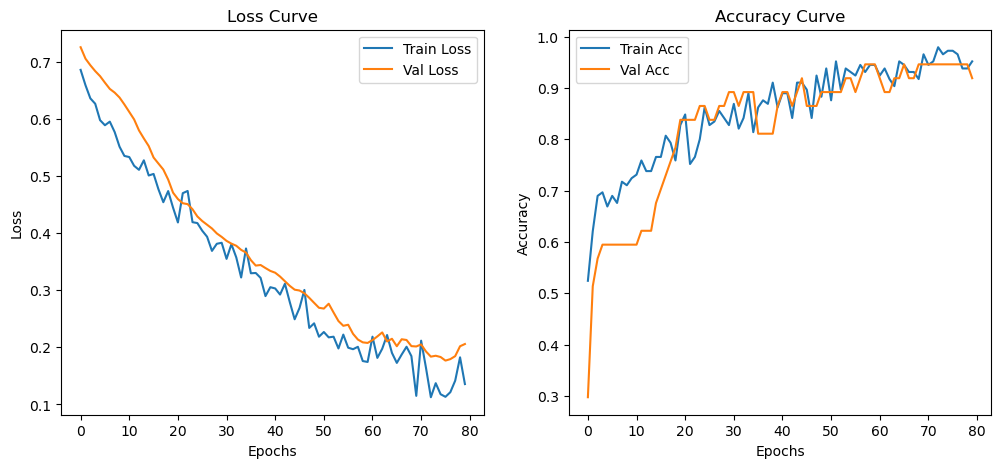

In [66]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Loss
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

# Call after training
plot_history(history)


In [67]:
best_model = torch.load("aom_com_best_checkpoint.pth")['model_state']
model.load_state_dict(best_model)

C:\Users\User\AppData\Local\Temp\ipykernel_17808\1447696919.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("aom_com_best_checkpoint.pth")['model

<All keys matched successfully>


Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95        22
    Abnormal       0.93      0.93      0.93        15

    accuracy                           0.95        37
   macro avg       0.94      0.94      0.94        37
weighted avg       0.95      0.95      0.95        37



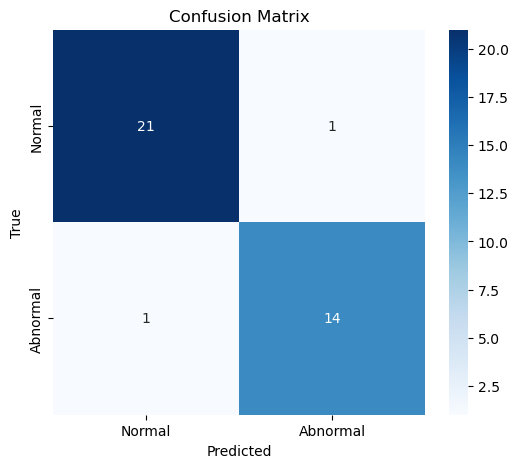


Sensitivity & Specificity per class:
Normal     -> Sensitivity: 0.955, Specificity: 0.933
Abnormal   -> Sensitivity: 0.933, Specificity: 0.955


In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_classification(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch["image"].to(device), batch["class"].to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Sensitivity & Specificity per class
    print("\nSensitivity & Specificity per class:")
    for i, cls in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        print(f"{cls:10s} -> Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f}")


class_names = ["Normal", "Abnormal"]  
evaluate_classification(model, val_loader, device, class_names)


In [19]:

from monai.transforms import LoadImage, EnsureChannelFirst, Resize, ScaleIntensity

def predict_image_multiclass(model, image_path, device):
    model.eval()

    loader = LoadImage(reader="PILReader")  
    img = loader(image_path)
    img = EnsureChannelFirst()(img)
    img = Resize((500, 500))(img)
    img = ScaleIntensity()(img)
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # [1, C, H, W]

    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)                   
        probs = F.softmax(outputs, dim=1)      
        probs = probs.cpu().numpy().flatten()  

        pred = np.argmax(probs)
        conf = probs[pred]

    class_names = ["Normal", "Abnormal", "Earwax"]
    print("\nPrediction Scores:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: {probs[i]:.4f}")

    return class_names[pred], float(conf)


In [70]:
torch.save(model, "AOM_COM_MODEL.pth")

In [23]:
image_path = "normal_276.tiff"
device = torch.device("cpu")
model = torch.load("mobilenetv3_3OM_classification.pth", map_location=device)

pred_class, confidence = predict_image_multiclass(model, image_path, device)
print(f"\nFinal Prediction: {pred_class} (Confidence: {confidence:.2f})")

C:\Users\User\AppData\Local\Temp\ipykernel_100\386102408.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("mobilenetv3_3OM_classification.pth", map_loc


Prediction Scores:
Normal: 0.8825
Abnormal: 0.0998
Earwax: 0.0177

Final Prediction: Normal (Confidence: 0.88)


In [29]:
from pytorch_grad_cam import GradCAM

In [33]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms.functional import to_pil_image

def show_gradcam_samples(model, dataloader, device, target_layers, class_names, samples_per_case=2):
    model.eval()
    tp_abnormal, fp_abnormal, fn_abnormal = [], [], []

    # Collect samples
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch["image"].to(device), batch["class"].to(device)
            outputs = model(images)
            probs_batch = F.softmax(outputs, dim=1)
            _, preds = torch.max(probs_batch, 1)

            for i in range(len(images)):
                probs = probs_batch[i].cpu().numpy()
                if labels[i].item() == 1 and preds[i].item() == 1:  # TP abnormal
                    if len(tp_abnormal) < samples_per_case:
                        tp_abnormal.append((images[i].cpu(), labels[i].item(), preds[i].item(), probs))
                elif labels[i].item() == 0 and preds[i].item() == 1:  # FP abnormal
                    if len(fp_abnormal) < samples_per_case:
                        fp_abnormal.append((images[i].cpu(), labels[i].item(), preds[i].item(), probs))
                elif labels[i].item() == 1 and preds[i].item() == 0:  # FN abnormal
                    if len(fn_abnormal) < samples_per_case:
                        fn_abnormal.append((images[i].cpu(), labels[i].item(), preds[i].item(), probs))

            if (len(tp_abnormal) >= samples_per_case and 
                len(fp_abnormal) >= samples_per_case and 
                len(fn_abnormal) >= samples_per_case):
                break

    cases = [("TP Abnormal", tp_abnormal), 
             ("FP Abnormal", fp_abnormal), 
             ("FN Abnormal", fn_abnormal)]

    fig, axes = plt.subplots(len(cases), samples_per_case * 2, figsize=(6 * samples_per_case, 12))

    # Grad-CAM object
    cam = GradCAM(model=model, target_layers=target_layers)

    for row, (case_name, samples) in enumerate(cases):
        for col, (img, true_label, pred_label, probs) in enumerate(samples):
            input_tensor = img.unsqueeze(0).to(device)

            grayscale_cam = cam(input_tensor=input_tensor, targets=None)  # default target = predicted
            grayscale_cam = grayscale_cam[0, :]  # first (and only) image

            # Convert CHW → HWC
            img_np = np.transpose(img.numpy(), (1, 2, 0))
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
            overlay = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

            # Probabilities string
            probs_str = " | ".join([f"{cls}:{p:.2f}" for cls, p in zip(class_names, probs)])

            # Original
            axes[row, col * 2].imshow(img_np)
            axes[row, col * 2].set_title(f"{case_name}\nOriginal\nTrue={class_names[true_label]}, Pred={class_names[pred_label]}")
            axes[row, col * 2].axis("off")

            # CAM
            axes[row, col * 2 + 1].imshow(overlay)
            axes[row, col * 2 + 1].set_title(f"{case_name}\nGrad-CAM\nTrue={class_names[true_label]}, Pred={class_names[pred_label]}")
            axes[row, col * 2 + 1].axis("off")

    plt.tight_layout()
    plt.show()


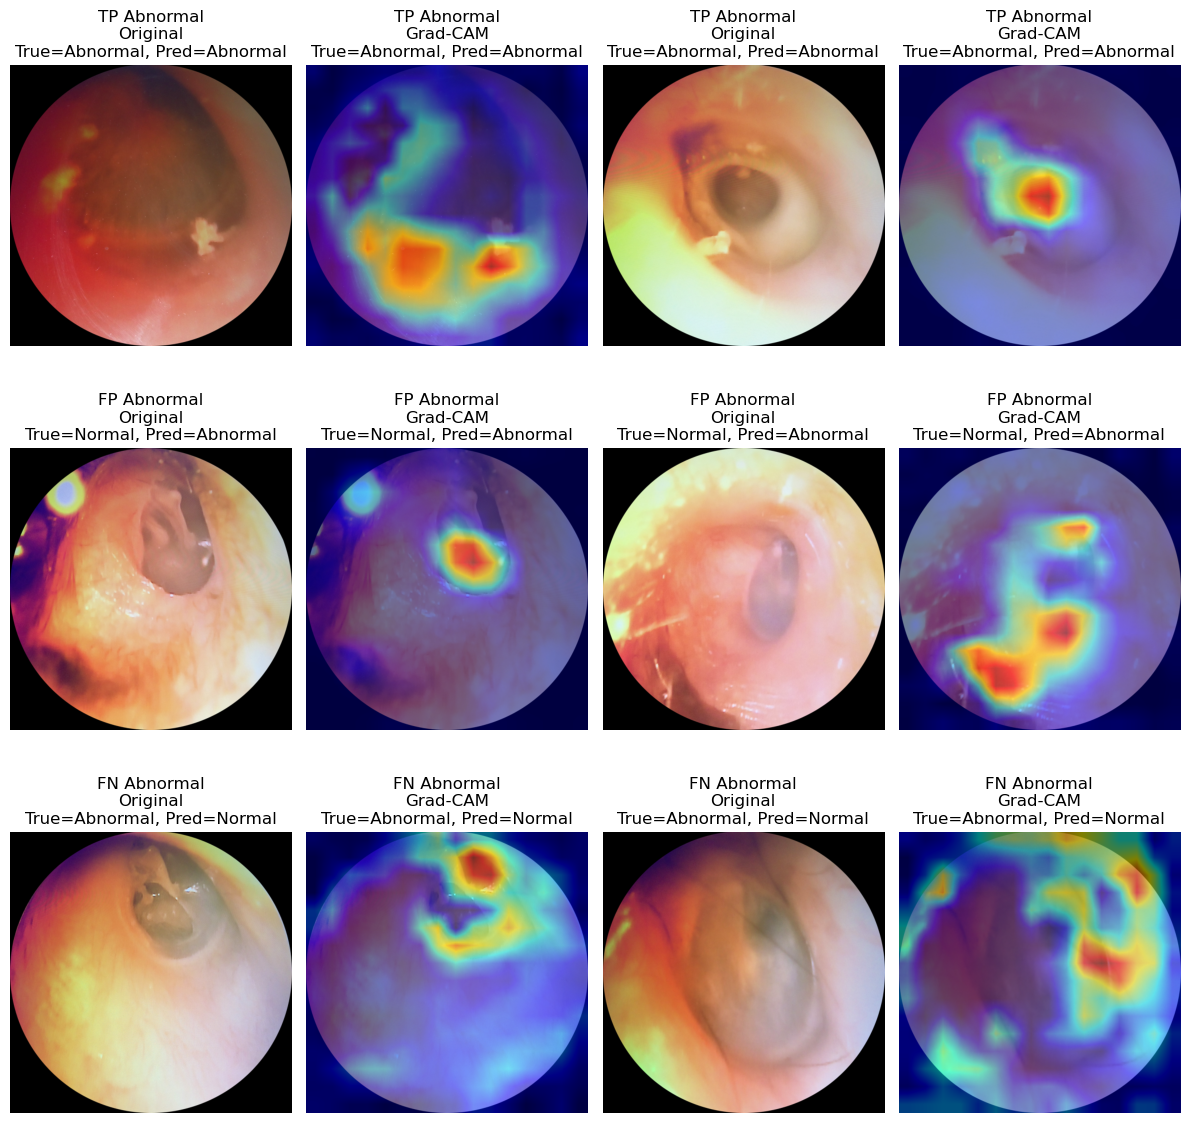

In [34]:
class_names = ["Normal", "Abnormal", "Earwax"]

# For MobileNetV3, the last convolutional block is usually:
target_layers = [model.features[-1]]

show_gradcam_samples(model, val_loader, device, target_layers, class_names, samples_per_case=2)
